<a href="https://colab.research.google.com/github/krishshhah/Wheat-Seeds-Neural-Network/blob/main/Wheat_seeds_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:
import pandas as pd

column_names = [
    'area',
    'perimeter',
    'compactness',
    'kernel_length',
    'kernel_width',
    'asymmetry_coefficient',
    'groove_length',
    'class' # 3 classes: 1,2,3
]

# Load the dataset from the URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pd.read_csv(url, sep='\s+', header=None, names=column_names)

# Display the first few rows of the DataFrame
print(df.head())

    area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   asymmetry_coefficient  groove_length  class  
0                  2.221          5.220      1  
1                  1.018          4.956      1  
2                  2.699          4.825      1  
3                  2.259          4.805      1  
4                  1.355          5.175      1  


In [45]:
df['class'] = df['class'].replace(1, 0)
df['class'] = df['class'].replace(2, 1)
df['class'] = df['class'].replace(3, 2)
print(df.head())

# classes have been set to start from 0, for index purposes

    area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   asymmetry_coefficient  groove_length  class  
0                  2.221          5.220      0  
1                  1.018          4.956      0  
2                  2.699          4.825      0  
3                  2.259          4.805      0  
4                  1.355          5.175      0  


In [46]:
df.describe()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,1.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,1.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,2.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,2.000000


In [47]:
# Create a model class to inherit the nn.Module

class Model(nn.Module):
  # input layer contains 4 inputs of the model
  # 1st hidden layer (l1) will have 10 neurons
  # 2nd hidden layer (l2) will have 10 neurons
  # output layer has 3 neurons to pick a flower

  def __init__(self, in_features=7, L1=20, L2=20, L3=20, out_features=3):
    super().__init__() # inherites from the superclass (nn.Module)
    self.fc1 = nn.Linear(in_features, L1) #fc1 = fully connected
    self.fc2 = nn.Linear(L1, L2) # stars with input features, moving FORWARD to the next stage
    self.fc3 = nn.Linear(L2, L3) # stars with input features, moving FORWARD to the next stage
    self.out = nn.Linear(L2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # relu = rectified linear unit. If output<0, it is 0. if >0, then use the output
    x = F.relu(self.fc2(x)) # moves the object forward
    x = F.relu(self.fc3(x)) # moves the object forward
    x = F.relu(self.out(x))

    return x

In [48]:
# Create random seed for randomisation
torch.manual_seed(41)
model = Model() # creates an instance

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
#train, test, split: set features (X) and targets (y)
X = df.drop('class', axis = 1) # selects only the targets, axis (columns)
y = df['class']

#convert to numpy arrays
X = X.values
y = y.values

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41) #80% train, 20% test

In [52]:
X_train = torch.FloatTensor(X_train) # converts numpy arrays to floatTensors (all features are decimals)
X_test = torch.FloatTensor(X_test)

In [53]:
y_train = torch.LongTensor(y_train) # converts numpy arrays to longTensors (all targets are integers)
y_test = torch.LongTensor(y_test)

In [54]:
# set a criterion of the model to measure the error, to measure how far off the predictions are from the actual data
criterion = nn.CrossEntropyLoss()
# choose an optimiser - using Adam optimiser, lr (learning rate) = if learning rate does not go down through each iteration, it should be lowered to learn slower
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # lower learning rate takes longer to train the model
#model.parameters() are the layers: fc1, fc2, fc3, out


In [55]:
# Train model, determining how many epochs needed. Epoch = 1 run through the entire network
epoch = 1000
losses = [] # to keep track of the losses to track progress
for i in range(epoch):
  # Go forward and get prediciton
  y_pred = model.forward(X_train) # using the features to move forward and get predicitive results

  # Measure the loss
  loss = criterion(y_pred, y_train) #predicted value vs y-train value
  losses.append(loss.detach().numpy())

  if i % 100 == 0:
    print(f'{epoch}: {i} and the loss is {loss}')

  # Back propogation = take the error rate of the forward propogation and feed it back through the neural network to tweak the weights
  optimiser.zero_grad() # Clears the old gradient values, ensuring gradients from the previous iterations don’t accumulate.
  loss.backward() # Performs backpropagation to calculate the new gradients of the loss with respect to each parameter (weights)
  optimiser.step() # Uses the calculated gradients to update the model's parameters, moving them toward values that minimize the loss

1000: 0 and the loss is 1.2057526111602783
1000: 100 and the loss is 0.20365874469280243
1000: 200 and the loss is 0.18164344131946564
1000: 300 and the loss is 0.1697489470243454
1000: 400 and the loss is 0.16509729623794556
1000: 500 and the loss is 0.1593054234981537
1000: 600 and the loss is 0.13945472240447998
1000: 700 and the loss is 0.10979465395212173
1000: 800 and the loss is 0.1169462576508522
1000: 900 and the loss is 0.10392238199710846


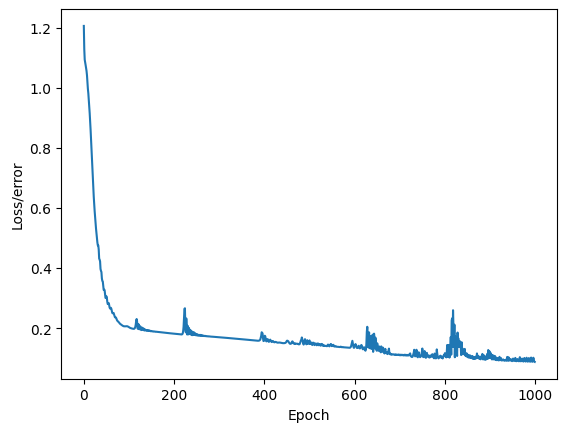

In [56]:
# Graphing out the losses
plt.plot(range(epoch), losses) # y-axis = losses
plt.ylabel("Loss/error")
plt.xlabel("Epoch")
plt.show()

In [57]:
# Evaluate deep learning results on our test data
with torch.no_grad():
   #turns off back propogation
   y_eval = model.forward(X_test) # testing the model on the new dataset, features from test set on predictions
   loss = criterion(y_eval, y_test) # find the loss error

In [58]:
loss

tensor(0.0936)

In [59]:
correct = 0
diff = []
with torch.no_grad():
  for i, data in enumerate(X_test): #features test set
    y_val = model.forward(data) #outcome of testing

    # tells us what type of flower out network thinks it is

    print(f'{i+1}.) {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}') # compares feature test to target test

    # correct or not
    if y_val.argmax().item() == y_test[i]: # if the index of the max tensor in the feature test == target test value
      correct +=1

    x = abs((y_val.argmax().item() - y_test[i]))
    diff.append(x)

print(f'We got {correct} correct!. Accuracy: {correct}/{len(y_test)} ({((correct/y_test.size(0))*100):.2f}%)')
print(f'The mean difference between predicted and actual quality: {sum(diff) / len(diff):.4f}')

1.) tensor([ 8.6150,  0.0000, 16.6214]) 	 2 	 2
2.) tensor([6.3466, 6.5642, 0.0000]) 	 1 	 1
3.) tensor([9.2927, 0.0000, 4.6359]) 	 0 	 0
4.) tensor([ 6.4779, 11.5207,  0.0000]) 	 1 	 1
5.) tensor([ 6.8172, 14.4747,  0.0000]) 	 1 	 1
6.) tensor([7.8979, 9.7998, 0.0000]) 	 1 	 1
7.) tensor([ 7.1447, 15.1391,  0.0000]) 	 1 	 1
8.) tensor([11.4513,  0.0000, 17.5469]) 	 2 	 2
9.) tensor([ 6.5927, 13.7774,  0.0000]) 	 1 	 1
10.) tensor([8.5738, 5.0926, 0.0000]) 	 0 	 0
11.) tensor([12.6942,  0.0000, 17.8558]) 	 2 	 2
12.) tensor([ 9.2957,  0.0000, 11.6941]) 	 2 	 2
13.) tensor([9.3306, 0.0000, 3.0959]) 	 0 	 0
14.) tensor([ 8.7851,  0.0000, 21.9883]) 	 2 	 2
15.) tensor([ 8.9906,  0.0000, 12.2551]) 	 2 	 2
16.) tensor([9.4201, 0.0000, 6.1369]) 	 0 	 0
17.) tensor([11.7969,  0.0000, 14.0824]) 	 2 	 2
18.) tensor([9.3068, 0.0000, 2.1221]) 	 0 	 0
19.) tensor([8.9711, 0.0000, 2.0954]) 	 0 	 0
20.) tensor([8.2958, 3.1058, 0.0000]) 	 0 	 0
21.) tensor([8.8137, 0.0000, 6.1805]) 	 0 	 0
22.) tenso

In [60]:
# Allows a new alcohol to be passed through the model to guess what the quality is
def testing(area, perimeter, compactness, kernel_length, kernel_width, asymmetry_coefficient, groove_length):
  new_seed = torch.tensor([area, perimeter, compactness, kernel_length, kernel_width, asymmetry_coefficient, groove_length])
  with torch.no_grad(): # without back propogation
    z = model(new_seed)
    z_quality = z.argmax().item()  # max index in tensor
    print(z)
    print(f'Class guess is: {z_quality} => ({z_quality+1})')


In [61]:
testing(14.88, 14.57, 0.8811, 5.554, 3.333, 1.018, 4.956)

tensor([10.2482,  0.0000,  3.1072])
Class guess is: 0 => (1)


In [62]:
# saving the model as a dictionary
torch.save(model.state_dict(), 'my_seeds_nn.pt')

In [63]:
# loading the saved model
new_model = Model()
new_model.load_state_dict(torch.load('my_seeds_nn.pt'))

# making sure it loaded successfully (checking instance variables)
new_model.eval()

<ipython-input-63-b7b7d15aec4a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('my_seeds_nn.pt'))


Model(
  (fc1): Linear(in_features=7, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=3, bias=True)
)